In [23]:
'''
assume GENERAL exponential utility and Gaussian distribution for N-1 dim, here is a simplfied neural network to learn the overall risk and fair measure transformation
based on primal and dual problem
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy import random
from scipy.stats import multivariate_normal
import pandas as df
import random
import matplotlib.pyplot as plt
import time

np.random.seed(1)
random.seed(1)

# Define a class Gaussian Distribution to Generate the Gaussion Distribution in N-1, -dimensions
class GaussianND:
    # initialize the class
    def __init__(self,n_samples,n_institutions,means,covariance,fixed_s):
        '''
        Input:  n_institutions: number N
              means: list 1 x N
              covariance: 2D array: N x N
        Output: Generate function: n_samples x N 
        '''
        # Initialize the parameters
        self.n_samples = n_samples
        self.N = n_institutions
        self.means = means
        self.covariance = covariance
        # Get the eigen value and eigen vectors, to help generate N-dimensional data
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.covariance)
        self.s = fixed_s
    def generate(self):
        component = []
        for i in range(self.n_samples):
            z = np.random.normal(0,1,self.N)
            x = self.means
            #print(x,"\n",self.covariance,"\n",self.eigen_values, "\n",self.eigen_vectors)
            for j in range(self.N):
              x += np.sqrt(self.eigen_values[j])*z[j]*self.eigen_vectors[j]
            x = np.append(x,self.s-np.sum(x))
            component.append(x)
        return component

def generate_sample(n_samples,n_institutions,means,covariance,fixed_s):
    '''
    return np.array: n_samples x n_institutions
    '''
    sample = GaussianND(n_samples,n_institutions,means,covariance,fixed_s).generate()
    #print(sample[0:3])
    #data = df.DataFrame(np.array(sample))#columns= ['Inst 1','Inst 2','Inst 3']
    return np.array(sample)

#generate a random positive semi-definite N*N integer matrix as integer covariace matrix, in [0,m]
def generate_covint(N,m):
    A = np.random.rand(N,N)*m
    D = np.dot(A,A.transpose())
    return D
#convert covariance to correlation matrix and sigma vector: cor = diag^{-1}*cov*diag^{-1}
def func_correlation(cov, N):
    diag = np.zeros((N,N))      #diagonal matrix
    sig = []
    for i in range(N):
        diag[i][i] = cov[i][i]
        sig.append(np.sqrt(cov[i][i]))
    inv_diag_sqrt = np.linalg.inv(np.sqrt(diag))
    #print("covariance\n", cov,"\ndiagnal matrix\n",diag,"\ninverse diag suare root(sigma)\n", inv_diag_sqrt)
    return (np.dot(np.dot(inv_diag_sqrt,cov),inv_diag_sqrt)), sig


# number of sample 
number_of_sample = 50000
number_of_test = 10000
n_institutions = 9
fixed_s = 15



#means = [0]*n_institutions
means = sorted([(random.random()*3+0.1) for i in range(n_institutions)]) #[5]*n_institutions


### control sigma < mean
covariance = generate_covint(n_institutions,1)
cor_mat = func_correlation(covariance, n_institutions)[0]
#sig = [random.uniform(0,min(means[i],10)) for i in range(n_institutions)]
sig = [random.uniform(0,1) for i in range(n_institutions)]
covariance = np.dot(np.dot(np.diag(sig),cor_mat),np.diag(sig))
print("Correlation:\n",cor_mat,"\n and Standard deviation: ",sig )
###


train_data = generate_sample(number_of_sample,n_institutions,means,covariance,fixed_s)
##val_data = generate_sample(number_of_val,n_institutions,means,covariance)
test_data = generate_sample(number_of_test,n_institutions,means,covariance,fixed_s)

n_institutions = 10

Correlation:
 [[1.         0.69636521 0.53737256 0.44310949 0.80040848 0.88379991
  0.57058305 0.54899297 0.782578  ]
 [0.69636521 1.         0.69206624 0.70880887 0.71866878 0.77061824
  0.79093166 0.70271291 0.90109849]
 [0.53737256 0.69206624 1.         0.84754383 0.71853314 0.62123292
  0.6631882  0.93876966 0.68595406]
 [0.44310949 0.70880887 0.84754383 1.         0.63848428 0.50482984
  0.84066672 0.88948408 0.75302503]
 [0.80040848 0.71866878 0.71853314 0.63848428 1.         0.68018215
  0.70474708 0.81922751 0.7684883 ]
 [0.88379991 0.77061824 0.62123292 0.50482984 0.68018215 1.
  0.47049513 0.53617135 0.77089533]
 [0.57058305 0.79093166 0.6631882  0.84066672 0.70474708 0.47049513
  1.         0.80795573 0.76914079]
 [0.54899297 0.70271291 0.93876966 0.88948408 0.81922751 0.53617135
  0.80795573 1.         0.70538967]
 [0.782578   0.90109849 0.68595406 0.75302503 0.7684883  0.77089533
  0.76914079 0.70538967 1.        ]] 
 and Standard deviation:  [0.02834747652200631, 0.835765

In [28]:
means# for first 9

[0.38157876032270466,
 0.5030927323372036,
 0.8652070772182651,
 1.4484731943662146,
 1.586305261275823,
 2.0547789181682887,
 2.391323856929842,
 2.4661700534065396,
 2.642301210811698]

In [29]:
import torch
#import torchvision
#import torchvision.transforms as transforms
#import matplotlib.pyplot as plt
#import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

## Training on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

'''if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
'''

batch_size=1000
## Tensor Initialization
data_=torch.from_numpy(train_data).to(device)
dataset = torch.utils.data.TensorDataset(data_)
trainloader = torch.utils.data.DataLoader(dataset,batch_size, shuffle = False)
# validation data
##validation_data=torch.from_numpy(val_data).to(device)
# testing data
testdata=torch.from_numpy(test_data).to(device)
dataset = torch.utils.data.TensorDataset(testdata)
testloader = torch.utils.data.DataLoader(dataset,batch_size, shuffle = False)

In [30]:
device

device(type='cuda', index=0)

# Dual first

In [31]:

# NN: Generator, return -alpha_B
class Generator(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        '''
        input_dim: number of uniform rvs, i.e. n_institutions 
        hidden_dim: list of hidden layer dimensions
        output_dim: number of classes i.e. n_institutions 
        '''
        super(Generator, self).__init__()
        model = [nn.Linear(input_dim, hidden_dim[0])]
        for i in range(len(hidden_dim)-1):
          model.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        model.append(nn.Linear(hidden_dim[-1], output_dim))
        self.model = nn.ModuleList(model)   
        

    def forward(self, x):
        '''
        Use ReLU nonlinearities in the layers, and nothing at the output.
        '''
        for i in range(len(self.model)-1):
          x = torch.relu(self.model[i](x))
        #x=torch.sigmoid(self.model[-1](x))
        #x=F.elu(self.model[-1](x))
        x=self.model[-1](x)
        return x

class Alpha_Loss(nn.Module):
    def __init__(self,utility,u_parameters, B, lam):
        """
        input:
            dQ_dP: current tranformation, siz M x 1
            utility function: 'exp','...'
            parameter for utitlity function: list of u_paramaters
        """
        super(Alpha_Loss, self).__init__()
        self.u = utility
        self.u_parameters = torch.tensor(u_parameters,device = 'cuda:0')
        self.B, self.lam = B, lam
        
    def calculate_u(self, z):
        '''
        input:
          z - tensor(batch, N)
        return:
          tensor(batch), utilitiess of Z across N
        '''
        if self.u == 'exp':
          return torch.sum(-torch.exp(-z*self.u_parameters)/self.u_parameters, dim=1)
        if self.u == 'exp_pairsum':
          return n_institutions**2/2-torch.square(torch.sum(torch.exp(-z*self.u_parameters), dim=1))/2
          #return torch.sub(-torch.square(torch.sum(torch.exp(-z*self.u_parameters), dim=1))/2, -n_institutions**2/2)
        
    def forward(self, dQ_dP, Z):
        """
        input:
            Z -- inputs: M x N
        return: value of loss function
        """
        # control lost
        sum_trans_Z = torch.reshape(torch.sum(Z, 1),(-1,1))*dQ_dP
        sum_u = self.calculate_u(Z)
        
        self.term1 = self.B - torch.mean(sum_u)
        self.term2 = torch.mean(sum_trans_Z)
        return torch.mean(sum_trans_Z)  + self.lam*torch.relu(self.B - torch.mean(sum_u))
    def print_loss(self):
        print("B-E U",self.term1.item())
        print("-alpha",self.term2.item())


In [32]:
# Neural Networks: approximate rho
class Net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        '''
        uniform tranformation for X_i, thus input 1-d and output 1-d
          input_dim: N
          hidden_dim: list of hidden layer dimensions
          output_dim: 1
        '''
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        model = [nn.Linear(input_dim, hidden_dim[0])]
        for i in range(len(hidden_dim)-1):
          model.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        model.append(nn.Linear(hidden_dim[-1], output_dim))
        self.model = nn.ModuleList(model)   
        

    def forward(self, x):
        '''
        Use ReLU nonlinearities in the layers, and relu at the output.
        '''
        for i in range(len(self.model)-1):
          x = torch.relu(self.model[i](x))
        #x=torch.sigmoid(self.model[-1](x))
        #x=F.elu(self.model[-1](x))
        #x=self.model[-1](x)
        x = torch.log(1 + torch.exp(self.model[-1](x)))# torch.relu(self.model[-1](x))+0.01
        return x/torch.mean(x)

class Loss(nn.Module):
    def __init__(self, u_paramaters, B):
        super(Loss, self).__init__()
        self.alphas = torch.tensor(u_paramaters).to(device)
        self.B = B
        self.beta = self.calculate_par()

    def calculate_par(self):
        beta = 0
        for alpha in self.alphas:
          beta += 1/alpha
        return beta
        
    def forward(self,data,dQ_dP,loss_alpha):
        """
        input:
            dQ_dP -- inputs: M x 1, generated from X by NN
            loss_alpha -- minimized 1 x 1 tensor under current dQ_dP, i.e. -alpha
        return: value of loss function
        """
        # control lost
        sum_X = torch.reshape(torch.sum(data, 1),(-1,1))
        
        return torch.mean(sum_X*dQ_dP, 0)  - loss_alpha

In [33]:
#u_parameters = sorted([random.uniform(0.8, 2) for i in range(n_institutions)]) #[1,2,3]

u_parameters  = [1.1122798436470818,#0.8676421969658913,
  1.2,
 1.3600655431719748,
 1.8948894071014162,
 1.942496453417903,
 2.0424170726028246,
 2.26928838290612,
 2.3344025824476655,
 2.6278998816486365,
 2.9867918993531175]

a =[round(num,3) for num in u_parameters]


In [34]:
utility, B, lam_alpha  = 'exp_pairsum',-1,0.1 #10 #'exp'，'exp_pairsum'

input_dim= n_institutions     # how many Variables are in the dataset
hidden_dim = [64,64]#[64,32]          # hidden layer dimensions
#output_dim= n_institutions   # number of classes


## Instantiating the transformer
net = Net(input_dim,hidden_dim ,1).to(device)
criterion = Loss(u_parameters,B)
learning_rate = 0.001#0.001
optimizer = optim.SGD(net.parameters(), lr=learning_rate,weight_decay=0.0001)

generator = Generator(n_institutions,[64,64],n_institutions).to(device)
gen_criterion = Alpha_Loss(utility,u_parameters, B, lam_alpha)
gen_optimizer = optim.SGD(generator.parameters(), lr=0.001, weight_decay=0.0001)#0.0005


In [35]:
device

device(type='cuda', index=0)

In [39]:
## 3. Training the neural network model
num_epochs = 1000#4000#2000

l_set = []
for j in range(1):
  print("Net {}".format(j+1))
  error_rate_paths=[[],[]]
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      if (epoch+1) % 200 == 0 and epoch+1<num_epochs:
        optimizer.param_groups[0]['lr'] /= 2
        gen_optimizer.param_groups[0]['lr'] /= 2
        #gen_criterion.lam *=2 #5

        

      print_bool = False
      if (epoch+1) % 50 ==0: 
        print_bool = True
        print("Epoch {}/{}".format(epoch+1,num_epochs))

      running_loss = 0.0
      dQ_dP = torch.tensor([])
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [N-dim inputs]
          input = data[0]
          # zero the parameter gradients, before each instance
          optimizer.zero_grad()
          # forward + backward + optimize
          output = net(input.float())   #dQ/dP , 500 x 1

          gen_optimizer.zero_grad()
          Z = generator(input.float())
          loss_alpha = gen_criterion(output,Z)

          loss = criterion(input,output,loss_alpha)
          loss.backward()

          for par in generator.parameters():
            par.grad *= -1
          gen_optimizer.step()
          optimizer.step()    # Does the update
          

          # print statistics
          running_loss += loss.item()
      l_set.append(running_loss / (i+1))
      if print_bool:
        gen_criterion.print_loss()
        ##print('loss function of alpha:',loss_alpha)
        print("Learn -rho, Training Loss: {:.3f}".format(running_loss / (i+1)))
  end_time = time.time()
  gen_criterion.print_loss()
  print('Finished Training for Net ',j+1)
  print(f"training time is {(end_time-start_time)/60:.2f} minutes")
 

Net 1
Epoch 50/1000
B-E U 0.640810489654541
-alpha -0.3800722062587738
Learn -rho, Training Loss: 15.323
Epoch 100/1000
B-E U -0.2812299132347107
-alpha -0.3307647705078125
Learn -rho, Training Loss: 15.332
Epoch 150/1000
B-E U 0.11312258243560791
-alpha -0.35285383462905884
Learn -rho, Training Loss: 15.335
Epoch 200/1000
B-E U -0.16720789670944214
-alpha -0.3377952575683594
Learn -rho, Training Loss: 15.342
Epoch 250/1000
B-E U 0.05457186698913574
-alpha -0.3500732183456421
Learn -rho, Training Loss: 15.342
Epoch 300/1000
B-E U -0.05456435680389404
-alpha -0.344195157289505
Learn -rho, Training Loss: 15.343
Epoch 350/1000
B-E U -0.11277902126312256
-alpha -0.3410801887512207
Learn -rho, Training Loss: 15.343
Epoch 400/1000
B-E U -0.06474649906158447
-alpha -0.3437769412994385
Learn -rho, Training Loss: 15.345
Epoch 450/1000
B-E U 0.048932790756225586
-alpha -0.35003113746643066
Learn -rho, Training Loss: 15.345
Epoch 500/1000
B-E U 0.018210649490356445
-alpha -0.3483750820159912
Lear

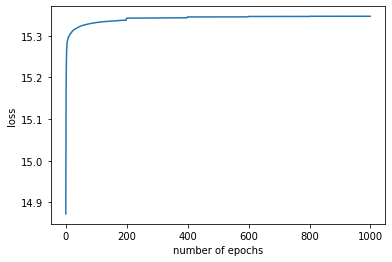

In [40]:

plt.plot(np.arange(num_epochs),l_set)# s = 0.1
#plt.ylim((52,53))
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.show() 

In [36]:
class ExpExample:
  def __init__(self,data,u_parameters, B):
    '''
    data: sample size M x N
    u_parameters: list, alpha's of exponential utility
    B: number
    Notes:  calculate explicit result presented in Thm 6.2, wich group size h=1
            "expentation" is calculated by sample, not MGF of X
    '''
    self.X = data
    self.alphas = u_parameters
    self.B = B
    self.beta, self.inv_alpha, self.gam, self.inv_gam = self.calculate_par()   # inv_alpha is a tensor
    self.M = self.X.size(dim=0)
    self.N = self.X.size(dim=1)
    self.sum_X = torch.sum(self.X, 1)
    self.d,self.exp_X, self.mean_exp_X = self.calculate_d()
    self.Y = self.calculate_Yk()
    self.EQ_Y = self.EQ_Y()
    self.QP = self.Q()
    self.rho = self.d-self.gam


  def calculate_par(self):
    beta = 0
    inv_alpha = []
    inv_gam = []
    gam = 0
    for alpha in self.alphas:
      beta += 1/alpha
      gam += 1/alpha*np.log(1/alpha)
      inv_gam.append(1/alpha*np.log(1/alpha))
      inv_alpha.append(1/alpha)
    inv_alpha = torch.tensor(inv_alpha, requires_grad=True).to(self.X.device)
    inv_gam = torch.tensor(inv_gam, requires_grad=True).to(self.X.device)
    return beta,inv_alpha, gam, inv_gam


  def calculate_d(self):
    exp_X = []
    for i in range(self.M):
      exp_X.append(torch.exp(-2*self.sum_X[i]/self.beta))
    exp_X=torch.tensor(exp_X, requires_grad=True).to(self.X.device)
    emp_mgf = torch.mean(exp_X)
    d = self.beta/2 * torch.log(self.beta**2/(n_institutions **2 - 2*self.B) * emp_mgf)
    return d,exp_X,emp_mgf

  def calculate_Yk(self):
    '''
    return: Y of size (M,N)
    '''
    Y = -self.X
    for i in range(self.M):
      # calculate every vector Y = (Y^1,...Y^N) line by line: Y = -X + 1/beta * (X_bar+d) * ALPHA(1,N)
      #print(self.sum_X[i].size,self.d,"\n",torch.add(self.sum_X[i],self.d),"\n times vector",torch.mul(self.d,self.inv_alpha))
      Y[i] += (1/self.beta *torch.add(self.sum_X[i],self.d) * self.inv_alpha- self.inv_gam)
    return Y
  
  def calculate_Eu(self):
    '''
    return: U(X^n+Y^n)
    '''
    sum_u = []
    for j in range(self.M):
      sum = 0
      for i in range(self.N):
        sum += -torch.exp(-self.alphas[i]* (self.X[j][i]+self.Y[j][i]))/self.alphas[i]
      sum_u.append(sum)
    sum_u=torch.tensor(sum_u, requires_grad=True).to(self.X.device)
    return torch.mean(sum_u)

  def EQ_Y(self):
    '''
    return: fair risk allocations E_{Q}[Y^n]
    '''
    trans_Yk = self.Y
    for i in range(self.M):
      trans_Yk[i] *= self.exp_X[i]/self.mean_exp_X
    EQ_Yk = torch.mean(trans_Yk,dim = 0)  #mean for each column i.e. n
    EQ_Yk = torch.tensor(EQ_Yk, requires_grad=True).to(self.Y.device)
    return EQ_Yk

  def Q(self):
    '''
    return: fair measure density dQ/dP
    '''
    return (self.exp_X/self.mean_exp_X).to(self.Y.device)

Example = ExpExample(testdata,u_parameters, B)#.to(device)


<ipython-input-36-14a0bb6ae8f1>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  EQ_Yk = torch.tensor(EQ_Yk, requires_grad=True).to(self.Y.device)


In [37]:
print("Overall risk/d/optimal of sum Y", torch.mean(torch.sum(Example.Y,1)))
print('rho is', Example.rho)

Overall risk/d/optimal of sum Y tensor(-15.3481, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
rho is tensor(-15.3481, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)


In [38]:
print("Individual risk/d/optimal Y^k", torch.mean(Example.Y,0))

Individual risk/d/optimal Y^k tensor([-0.8187, -0.8442, -1.0771, -1.4229, -1.5482, -1.9907, -2.2934, -2.3643,
        -2.5001, -0.4885], device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)


In [41]:

# Numerial: check accuracy of predicted fair individual allocation, with test data

output = torch.tensor([]).to(device)
l_alpha = 0.0
l = 0.0
for i, data in enumerate(testloader, 0):
  testinput = data[0]
  testoutput = net(testinput.float())  
  testZ = generator(testinput.float())
  loss_alpha = gen_criterion(testoutput,testZ)
  loss = criterion(testinput,testoutput,loss_alpha)
  l_alpha += loss_alpha.item()
  print(i,loss_alpha.item())
  l += loss.item()
  output = torch.cat([output,testoutput])
gen_criterion.print_loss()
print("Testing loss: {:.3f}".format(l / (i+1)))

diff = output.view(-1) - Example.QP

relative_error = torch.mean(diff**2)**0.5/ torch.mean(Example.QP**2)**0.5
print("From numerical, mean is ",torch.mean(output), 'optimal mean is',torch.mean(Example.QP) )
#print(f"Relative L2 Error rate for over 50000 samples: {relative_error.item()*100:.2f}%.")

0 -0.34638601541519165
1 -0.3472079634666443
2 -0.3468417525291443
3 -0.34732988476753235
4 -0.3469654321670532
5 -0.34722253680229187
6 -0.34667345881462097
7 -0.3474437892436981
8 -0.3473479747772217
9 -0.3469405174255371
B-E U -0.009709060192108154
-alpha -0.3469405174255371
Testing loss: 15.347
From numerical, mean is  tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>) optimal mean is tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [42]:
# alpha =beta/2 * E[dQ_dP * ln(dQ_dP)]+gamma-beta/2*log(beta**2/(N^2-2B))
print('Estimated alpha: see above or', -l_alpha/(i+1), '\nTheoritical alpha on formula: ',Example.beta/2*torch.mean(Example.QP*torch.log(Example.QP),0)+Example.gam - Example.beta/2*np.log(Example.beta**2/(n_institutions**2-2*B)))

Estimated alpha: see above or 0.34703593254089354 
Theoritical alpha on formula:  tensor(0.3481, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)


Metric to evaluate $dQ/dP$

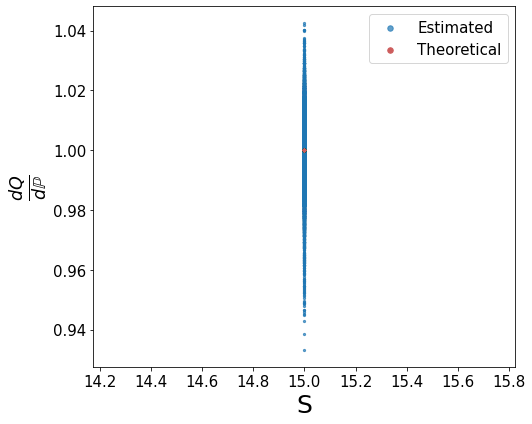

In [43]:
#===================================================#
# figure setup fonts and so on... 
# the label and font size should be adjusted such that 
# the figure fits well into ACM template
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=22) 
plt.rc('axes', labelsize=25)
plt.rcParams["figure.figsize"] = (7.5, 6)
#===================================================#

## Graph fitting
fig = plt.figure()
plt.scatter(torch.sum(testdata,1).detach().cpu().numpy(),output.detach().cpu().numpy(),s = 5,label = "Estimated", alpha = 0.7)
plt.scatter(torch.sum(testdata,1).detach().cpu().numpy(),Example.QP.detach().cpu().numpy(),s = 5, color="indianred", label = "Theoretical")
#plt.scatter(torch.sum(testdata,1).detach().cpu().numpy(),np.log(output.detach().cpu().numpy()),s = 5,label = "Estimated", alpha = 0.7)
#plt.scatter(torch.sum(testdata,1).detach().cpu().numpy(),np.log(Example.QP.detach().cpu().numpy()),s = 5, color="indianred", label = "Theoretical")
#plt.scatter(torch.sum(testdata,1).detach().cpu().numpy(),-(2+0.4)/(Example.beta)*torch.sum(testdata,1).detach().cpu().numpy()+3.5-np.log(Example.mean_exp_X.detach().cpu().numpy()),s = 5, color="black", label = "slope -2.4/beta")


#plt.ylim(0,10)
plt.xlabel("S")# = \sum_{n=1}^N X^n
plt.ylabel(r"$\frac{dQ}{d\mathbb{P}}$")
#plt.legend()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.tight_layout()
fig.savefig("dQdP_vs_sumX.pdf")

In [ ]:
## Relative Entropy
#def relative_entropy(QP_hat,QP):
#  relative_e = torch.sum(QP_hat * torch.log(QP_hat/QP))
#  return relative_e
#print("KL divergence: ",relative_entropy(output.view(-1),Example.QP)/number_of_test)
#mid_dist = (output.view(-1) + Example.QP)/2
#print("Jensen-Shannon divergence: ",relative_entropy(output.view(-1),mid_dist)/2+relative_entropy(mid_dist,Example.QP)/2)

KL divergence:  tensor(0.0690, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Jensen-Shannon divergence:  tensor(870.1619, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [ ]:
## Wasserstein Distance:  the minimum amount of “work” required to transform one to another
#from scipy.stats import wasserstein_distance
#print("Wasserstein Distance: ",wasserstein_distance(output.view(-1).cpu().detach().numpy(),Example.QP.cpu().detach().numpy()))

Wasserstein Distance:  0.034588065255513084


In [44]:
## Another Relative L1
re_1 = torch.mean(torch.abs(diff))/ torch.mean(torch.abs((Example.QP))) # output.view(-1) +
print(f"Relative L1 Error rate: {re_1.item()*100:.2f}%.")

Relative L1 Error rate: 0.92%.


# Primal and Combined with dual

**Compare $E_Q[Y^n]$**

In [47]:
## Copy from learning for risk measures.... train NN to get Y's
# Neural Networks
class Net_Y(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        '''
        input_dim: how many variables are in the dataset, i.e. n_institutions 
        hidden_dim: list of hidden layer dimensions
        output_dim: number of classes i.e. n_institutions 
        '''
        super(Net_Y, self).__init__()
        # an affine operation: y = Wx + b
        model = [nn.Linear(input_dim, hidden_dim[0])]
        for i in range(len(hidden_dim)-1):
          model.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        model.append(nn.Linear(hidden_dim[-1], output_dim))
        self.model = nn.ModuleList(model)   
        

    def forward(self, x):
        '''
        Use ReLU nonlinearities in the layers, and nothing at the output.
        '''
        for i in range(len(self.model)-1):
          x = torch.relu(self.model[i](x))
        #x=torch.sigmoid(self.model[-1](x))
        #x=F.elu(self.model[-1](x))
        #x=F.leaky_relu(self.model[-1](x))
        #x=torch.exp(self.model[-1](x))
        x=self.model[-1](x)
        return x

class Loss_Y(nn.Module):
    def __init__(self, utility,u_paramaters, B, lam, mu):
        """
        input:
            utility function: 'exp','...'
            parameter for utitlity function: list of u_paramaters
        """
        super(Loss_Y, self).__init__()
        self.u = utility
        self.u_parameters = torch.tensor(u_paramaters, device="cuda")
        self.B, self.lam, self.mu  = B, lam, mu
        
    def calculate_u(self, x):
        if self.u == 'exp':
          return torch.sum(-torch.exp(-x*self.u_parameters)/self.u_parameters, dim=1)
        if self.u == 'exp_pairsum':
          return n_institutions**2/2-torch.square(torch.sum(torch.exp(-x*self.u_parameters), dim=1))/2
        
    def forward(self, X, Y):
        """
        input:
            X -- inputs: M x N
            Y -- outputs: M x N
        return: value of loss function
        """
        M = X.size(dim=0)
        # control lost
        sum_Y = torch.sum(Y, 1)
        sum_u = self.calculate_u(X+Y)
        
        self.term1 = self.B - torch.mean(sum_u)
        self.term2 = torch.var(sum_Y)
        self.term3 = torch.mean(sum_Y)
        self.term4 = torch.mean(sum_u)
        
        return torch.mean(sum_Y)  + self.mu*torch.std(sum_Y) + self.lam*torch.relu(self.B - torch.mean(sum_u))#**2


    def print_loss(self):
        print("B-sum u_n",self.term1.item(),"\nU(Xn+Yn)",self.term4.item(), "\nvar(sumY)",self.term2.item(), "\nmean(sumY)", self.term3.item())

utility, B, lam, mu = 'exp_pairsum',B, .02, 1  ######1,5

input_dim= n_institutions     # how many Variables are in the dataset
hidden_dim = [64,64]          # hidden layer dimensions
output_dim= n_institutions   # number of classes


## Instantiating the classifier
net_Y = Net_Y(input_dim,hidden_dim ,output_dim).to(device)
criterion_Y = Loss_Y(utility,u_parameters, B, lam, mu)
learning_rate = 0.00001#0.0001
optimizer = optim.SGD(net_Y.parameters(), lr=learning_rate, weight_decay=0.0001)


In [48]:
## 3. Training the neural network model
num_epochs = 3000#1600#3000 # 800,200? 20%

l_set = []
for j in range(1):
  print("Net {}".format(j+1))
  error_rate_paths=[[],[]]
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      if (epoch+1) % 1000 == 0 and epoch+1<num_epochs: # 1000
        optimizer.param_groups[0]['lr'] /= 1
        
        criterion_Y.lam *= 10
        criterion_Y.mu *= 10
        

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [N-dim inputs]
          input = data[0]
          # zero the parameter gradients, before each instance
          optimizer.zero_grad()
          # forward + backward + optimize
          output_tmp = net_Y(input.float())

          loss = criterion_Y(input, output_tmp)
          #print('loss',loss,'\n',criterion_Y.print_loss())
          #print(loss.item())
          loss.backward()
          optimizer.step()    # Does the update

          # print statisticsç
          running_loss += loss.item()
      l_set.append(running_loss / (i+1))
      if epoch % 50 ==0:
        print("Epoch {}/{}, Training Loss(rho): {:.3f}".format(epoch+1,num_epochs, running_loss / (i+1)))
  end_time = time.time()
  criterion_Y.print_loss()
  print('Finished Training for Net ',j+1)

print(f"training time is {(end_time-start_time)/60:.2f} minutes")

Net 1
Epoch 1/3000, Training Loss(rho): nan
Epoch 51/3000, Training Loss(rho): nan


KeyboardInterrupt: ignored

In [ ]:
plt.plot(np.arange(num_epochs),l_set)# s = 0.1
#plt.ylim((52,53))
plt.xlabel('number of epochs')
plt.ylabel('loss during calculating Y^i')
plt.show() 

In [ ]:
Y_output = net_Y(testdata.float())
EQY_output = torch.mean(Y_output*output,0)
print('NN Y.    ',np.round(torch.mean(Y_output,0).cpu().detach().numpy(), 2))
print('optimal Y',np.round(torch.mean(Example.Y,0).cpu().detach().numpy(), 2))
print('NN EQY.    ',np.round(EQY_output.cpu().detach().numpy(), 2))
print('optimal EQY',np.round(Example.EQ_Y.cpu().detach().numpy(), 2))

In [ ]:
torch.sum(EQY_output)

In [ ]:
(EQY_output-Example.EQ_Y).cpu().detach().numpy()

In [ ]:
import matplotlib.pyplot as plt
diff_EXP = torch.abs((EQY_output-Example.EQ_Y))#/Example.EQ_Y
plt.scatter(np.arange(n_institutions),diff_EXP.cpu().detach().numpy(),s = 10, color="indianred")
#plt.ylim((0, 0.1))
plt.xlabel('n')
plt.title(r'Scatterplot of diff between estimated $E_Q[Y^n]$ and real $E_Q[Y^n]$' )#relative 
#plt.legend()
plt.show()
print(f"Relative error of predicted fair risk allocation: {torch.mean(diff_EXP)*100:.3f}%.")
#print(diff_EXP*Example.EQ_Y, Example.EQ_Y)

In [ ]:
torch.mean(diff_EXP)/torch.mean(torch.abs(Example.EQ_Y))

In [ ]:
# wrong
class ExpExample:
  def __init__(self,data,u_parameters, A):
    '''
    data: sample size M x N
    u_parameters: list, alpha's of exponential utility
    B: number
    Notes:  calculate explicit result presented in Thm 6.2, wich group size h=1
            "expentation" is calculated by sample, not MGF of X
    '''
    self.X = data
    self.alphas = u_parameters
    self.A = A
    self.beta, self.inv_alpha, self.gam, self.inv_gam = self.calculate_par()   # inv_alpha, inv_gam is a tensor
    self.M = self.X.size(dim=0)
    self.N = self.X.size(dim=1)
    self.sum_X = torch.sum(self.X, 1)
    self.exp_X, self.mean_exp_X = self.calculate_XEX()
    self.d,self.lamb_hat = self.calculate_d_lambhat()
    self.Y = self.calculate_Yk()
    self.EQ_Y = self.EQ_Y()
    self.QP = self.Q()
    #self.EU = self.calculate_Eu()


  def calculate_par(self):
    beta = 0
    inv_alpha = []
    inv_gam = []
    gam = 0
    for alpha in self.alphas:
      beta += 1/alpha
      gam += 1/alpha*np.log(1/alpha)
      inv_gam.append(1/alpha*np.log(1/alpha))
      inv_alpha.append(1/alpha)
    inv_alpha = torch.tensor(inv_alpha, requires_grad=True).to(self.X.device)
    inv_gam = torch.tensor(inv_gam, requires_grad=True).to(self.X.device)
    return beta,inv_alpha, gam, inv_gam

  def calculate_XEX(self):
    exp_X = []
    for i in range(self.M):
      exp_X.append(torch.exp(-2*self.sum_X[i]/self.beta))
    exp_X=torch.tensor(exp_X, requires_grad=True).to(self.X.device)
    emp_mgf = torch.mean(exp_X)
    
    return exp_X,emp_mgf

  def calculate_d_lambhat(self):
    lamb_hat = torch.exp(-2/self.beta*(self.A+self.beta+self.gam-self.beta/2*np.log(self.beta)-self.beta/2*torch.log(self.mean_exp_X)))
    d = -self.beta + self.beta/2*np.log(self.beta)-self.beta/2*torch.log(lamb_hat)+self.beta/2 * torch.log(self.mean_exp_X)
    return d,lamb_hat

  def calculate_Yk(self):
    '''
    return: Y of size (M,N)
    '''
    Y = -self.X
    for i in range(self.M):
      # calculate every vector Y = (Y^1,...Y^N) line by line: Y = -X + 1/beta * (X_bar+d) * inv_alpha(1,N)-inv_gam(1,N)
      #print(self.sum_X[i].size,self.d,"\n",torch.add(self.sum_X[i],self.d),"\n times vector",torch.mul(self.d,self.inv_alpha))
      Y[i] += (1/self.beta *torch.add(self.sum_X[i],self.d) * self.inv_alpha - self.inv_gam)
    return Y
  
  def calculate_Eu(self):
    '''
    return: U(X^n+Y^n)
    '''
    sum_u = []
    for j in range(self.M):
      sum = 0
      for i in range(self.N):
        sum += torch.exp(-self.alphas[i]* (self.X[j][i]+self.Y[j][i]))
      sum = n_institutions**2/2-sum**2/2
      #print(j,sum)
      sum_u.append(sum)
    sum_u=torch.tensor(sum_u, requires_grad=True).to(self.X.device)
    return torch.mean(sum_u)

  def EQ_Y(self):
    '''
    return: fair risk allocations E_{Q}[Y^n]
    '''
    trans_Yk = self.Y
    for i in range(self.M):
      trans_Yk[i] *= self.exp_X[i]/self.mean_exp_X
    EQ_Yk = torch.mean(trans_Yk,dim = 0)  #mean for each column i.e. n
    EQ_Yk = torch.tensor(EQ_Yk, requires_grad=True).to(self.Y.device)
    return EQ_Yk

  def Q(self):
    '''
    return: fair measure density dQ/dP
    '''
    return (self.exp_X/self.mean_exp_X).to(self.Y.device)

Example = ExpExample(testdata,u_parameters, A = -running_loss / (i+1))#10.75)#.to(device)#running_loss / (i+1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
